# Luminosity Function

In this notebook is all the code that goes into generating the luminosity functions, mass functions, occupation fractions, etc. 

In [2]:
# first we import all relevant packages
from bulk import * # bulk.py stores a lot of my personal functions, i.e. for reading from the .data files and such
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic
import pandas as pd

In [3]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

# Satellite Luminosity Function with Observational Comparisons

Cumulative satellite luminosity functions for the Justice League simulations. Red/orange lines show simulated LFs, with thin lines extending below the high-resolution limit of 100 star particles. Observational luminosity functions, presented for comparison, are shown with blue/purple and in dashed lines. Observational data comes from McConnachie (2012) for the Milky Way and M31, Crnojevic et al. (2019) for Centaurus A, and Bennet et al. (2019) for M101. For M94, we include the two satellites recently discovered by Smercina et al. (2018), along with two previously known satellites KK 160 and IC 3687. Data for M81 comes from Chiboucas et al. (2013) and includes the recently discovered satellite from Smercina et al. (2017), using the Mr′ to MV conversion provided by Crnojevic et al. (2019). Values in parentheses are the host galaxy’s stellar mass, in $10^{10}$ M$_\odot$ (for simulations, this is determined from $M_R$ using a mass-to-light ratio of 1).

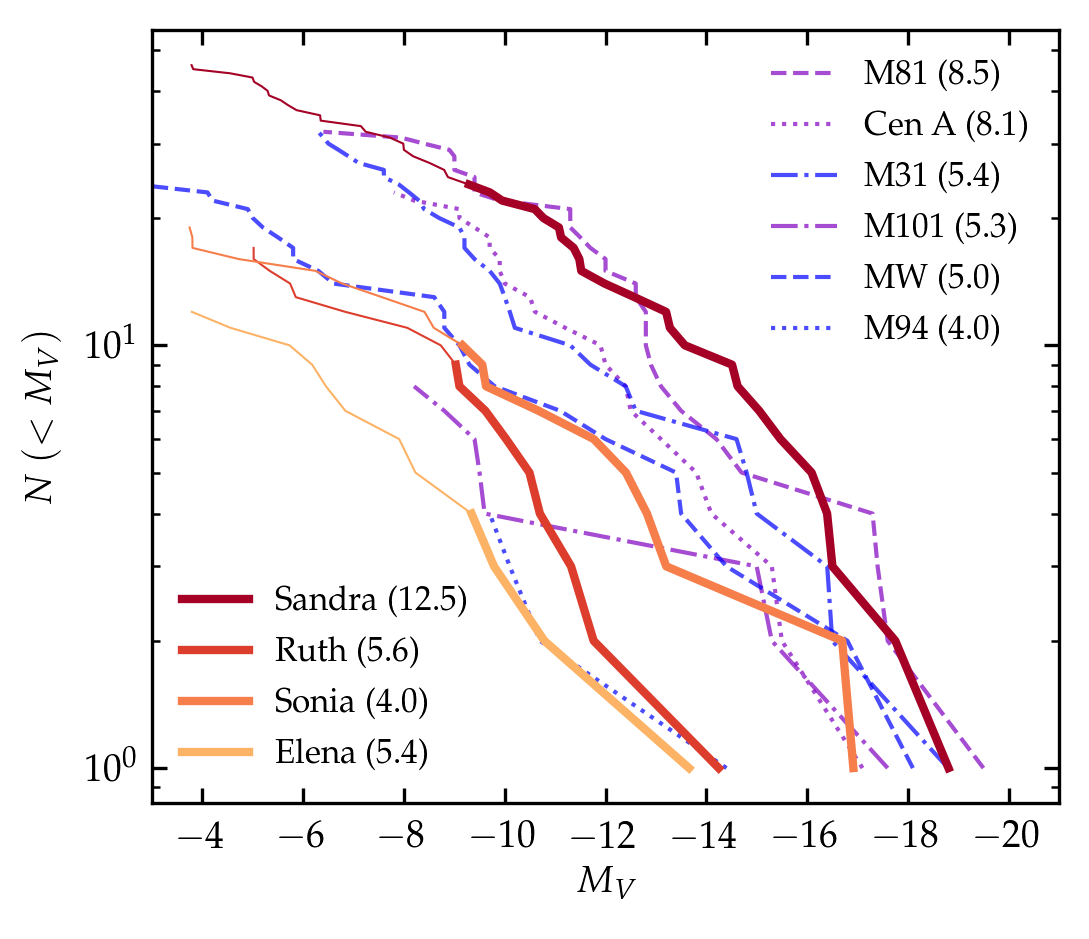

In [33]:
# Observational Data

MW = [-14.4,-13.5,-1.5,-4.2,-2.7,-2.5,-2.7,-4.1,-5.8,-18.1,-16.8,-6.3,-8.8,-8.8,-11.1,-9.3,-5.5,-9.1,-6.6,-13.4,
      -5.8,-4.9,-5.2,-5.0,-8.6,-9.8,-12] # McConnachie (2012) # MW magnitude is unknown 
CenA = [-9.4,-8.2,-12.5,-12.4,-9.9,-7.8,-9.1,-9.9,-15.5,-9.7,-13.8,-13.1,-9.1,-9.7,-15.3,-11.2,-14.1,
       -10.5,-17.1,-10.6,-12.0,-10.0,-11.9] # Crnojevic et al. (2019) # Cen A Magnitude -21 (removed)
M31 = [-16.4,-8.1,-16.5,-8.7,-11.7,-7.9,-10,-9.7,-7.1,-6.9,-9.1,-7.6,-10.2,-6.3,-6.4,-14.6,-9.9,-8.4,-9.4,-6.7,
       -12.4,-14.8,-8.3,-9.2,-18.8,-7.6,-12.6,-6.5,-15,-10.1,-11.3,-9.2] # McConnachie (2012) # M31 magnitude is ~ -22
M101 = [-9.5,-8.2,-8.8,-9.4,-9.6,-15.0,-15.3,-17.6] # Bennet et al (2019) # M101 magnitude -20.8 (removed)
M94 = np.array([-10.1,-9.7]) # first two entries from Smercina et al. (2018)
M94 = np.append(M94,[-14.4,-10.7]) # eyeballed values from Fig 7 in Bennett et al (2019) (cannot find paper on these two)
M81_r = np.array([-13.3,-11.7,-18.0,-19.9 ,-11.7,-13.2,-13.2,-6.8,-9.4,-13.9,-13.0,-9.8,-9.4,-13.0,-13.2,-17.8,-12.4 ,-8.8,-9.8,-9.3,-12.1,-17.7,-15.1,-12.4,-13.5,-9.8,-14.6,-10.3,-11.7,-11.9,-9.4])
# the above is direclty from Table 3 of Chiboucas et al
M81 = M81_r + 0.4 # emperical relation from Crnojevic et al (2019)
M81 = np.append(M81, -7.94) # from Smercina et al (2018)

# Plotting Setup
nbins = 10
names = ['h148','h229','h242','h329']
labels = ['Sandra (12.5)','Ruth (5.6)','Sonia (4.0)','Elena (5.4)']
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']


obs_mags = [M81, CenA, M31, M101, MW, M94]
obs_names = [r'M81 ($8.5$)', r'Cen A ($8.1$)', r'M31 ($5.4$)', r'M101 ($5.3$)', r'MW ($5.0$)', r'M94 ($4.0$)']
obs_colors = ['#8000bf', '#8000bf', 'b', '#8000bf', 'b', 'b'] 
obs_styles = ['--',':','-.','-.','--',':']


fig,ax = plt.subplots(1,1,figsize=(3.7,3.2),dpi=300)

obs_plots, obs_labels = [], [] # store the plot and label objects in these lists
sim_plots, sim_labels = [], [] # this is just a way to have two legends in different places

# calcualte observational LFs from lists of magnitudes
for mags,name,color,style in zip(obs_mags, obs_names, obs_colors,obs_styles):  
    y = np.array(range(len(mags)))+1 # range of the list
    x = np.sort(np.array(mags,dtype=float)) # sorted list of magnitudes
    
    p, = ax.plot(x,y,linestyle=style,mew=0,ms=3,linewidth=1.,color=color,label=name,alpha=0.7,zorder=1)
    obs_plots.append(p)
    obs_labels.append(name)
                
for name, label, color in zip(names, labels, colors):
    # read the data, and get magnitudes for those halos whose host is halo 1 (i.e. whichHost(data)==1)
    data = read_file(name)
    data = data[whichHost(data)==1]
    mags = data['V_mag']

    # the y axis is range of mags (+1) since we sort the mags and want each magnitude to bring change the lumfunc by 1
    # the x axis is the sorted magnitudes 
    y = np.array(range(len(mags)))+1
    x = np.sort(np.array(mags,dtype=float)) 

    # plot the data as a thin line (since this includes the cutoff)
    ax.plot(x,y,'-',linewidth=0.5,linestyle='-',color=color,zorder=5)

    # now plot the regular size line above the cutoff
    data = read_file(name)
    data = data[(data.n_star > 100) & (whichHost(data)==1)]
    mags = data['V_mag']

    y = np.array(range(len(mags)))+1
    x = np.sort(np.array(mags,dtype=float))
    
    p, = ax.plot(x,y,'-',linestyle='-',mew=0,ms=5,linewidth=2,color=color,label=label,zorder=10)
    sim_plots.append(p)
    sim_labels.append(label)
        


ax.set_ylabel(r'$N\ (<M_V)$')
ax.set_xlabel(r'$M_V$')
ax.invert_xaxis()
ax.set_xlim(-3,-21)
ax.semilogy()
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xticks([-4, -6, -8, -10, -12, -14, -16, -18, -20])
# ax.grid(alpha=0.2)

l1 = ax.legend(obs_plots, obs_labels, loc='upper right', ncol=1, frameon=False, prop={'size':8})
l2 = ax.legend(sim_plots, sim_labels, loc='lower left', ncol=1, frameon=False, prop={'size':8})
ax.add_artist(l1)

plt.tight_layout()
# plt.savefig('plots/LF_F19.png',dpi=300)
plt.show()

# Satellite Luminosity Functions with SAGA Comparisons

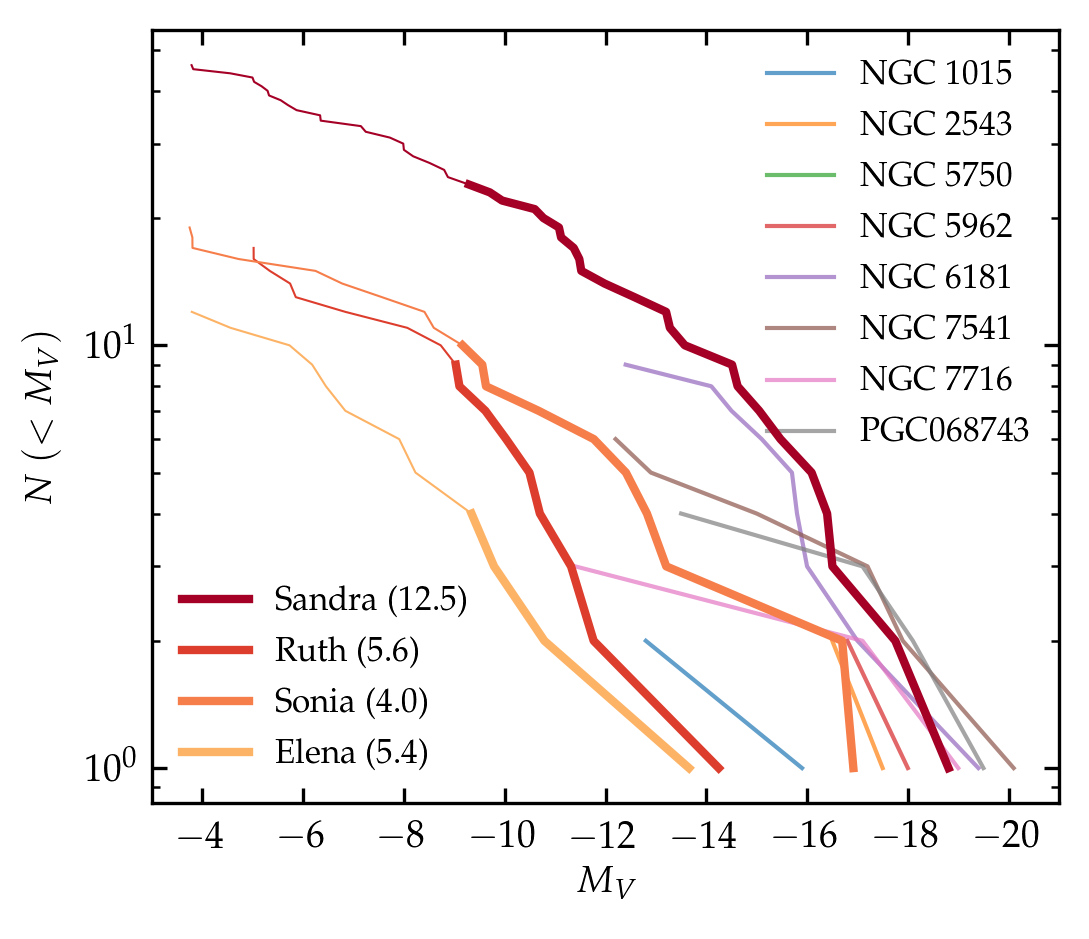

In [4]:
# Observational Data

MW = [-14.4,-13.5,-1.5,-4.2,-2.7,-2.5,-2.7,-4.1,-5.8,-18.1,-16.8,-6.3,-8.8,-8.8,-11.1,-9.3,-5.5,-9.1,-6.6,-13.4,
      -5.8,-4.9,-5.2,-5.0,-8.6,-9.8,-12] # McConnachie (2012) # MW magnitude is unknown 
CenA = [-9.4,-8.2,-12.5,-12.4,-9.9,-7.8,-9.1,-9.9,-15.5,-9.7,-13.8,-13.1,-9.1,-9.7,-15.3,-11.2,-14.1,
       -10.5,-17.1,-10.6,-12.0,-10.0,-11.9] # Crnojevic et al. (2019) # Cen A Magnitude -21 (removed)
M31 = [-16.4,-8.1,-16.5,-8.7,-11.7,-7.9,-10,-9.7,-7.1,-6.9,-9.1,-7.6,-10.2,-6.3,-6.4,-14.6,-9.9,-8.4,-9.4,-6.7,
       -12.4,-14.8,-8.3,-9.2,-18.8,-7.6,-12.6,-6.5,-15,-10.1,-11.3,-9.2] # McConnachie (2012) # M31 magnitude is ~ -22
M101 = [-9.5,-8.2,-8.8,-9.4,-9.6,-15.0,-15.3,-17.6] # Bennet et al (2019) # M101 magnitude -20.8 (removed)
M94 = np.array([-10.1,-9.7]) # first two entries from Smercina et al. (2018)
M94 = np.append(M94,[-14.4,-10.7]) # eyeballed values from Fig 7 in Bennett et al (2019) (cannot find paper on these two)
M81_r = np.array([-13.3,-11.7,-18.0,-19.9 ,-11.7,-13.2,-13.2,-6.8,-9.4,-13.9,-13.0,-9.8,-9.4,-13.0,-13.2,-17.8,-12.4 ,-8.8,-9.8,-9.3,-12.1,-17.7,-15.1,-12.4,-13.5,-9.8,-14.6,-10.3,-11.7,-11.9,-9.4])
# the above is direclty from Table 3 of Chiboucas et al
M81 = M81_r + 0.4 # emperical relation from Crnojevic et al (2019)
M81 = np.append(M81, -7.94) # from Smercina et al (2018)

# Setup
nbins = 10
names = ['h148','h229','h242','h329']
labels = ['Sandra (12.5)','Ruth (5.6)','Sonia (4.0)','Elena (5.4)']
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']


obs_mags = [M81, CenA, M31, M101, MW, M94]
obs_names = [r'M81 ($8.5$)', r'Cen A ($8.1$)', r'M31 ($5.4$)', r'M101 ($5.3$)', r'MW ($5.0$)', r'M94 ($4.0$)']
obs_colors = ['#8000bf', '#8000bf', 'b', '#8000bf', 'b', 'b'] 
obs_styles = ['--',':','-.','-.','--',':']


fig,ax = plt.subplots(1,1,figsize=(3.7,3.2),dpi=300)

obs_plots, obs_labels = [], []
sim_plots, sim_labels = [], []

SAGA = pd.read_csv('SAGA_data_cleaned.csv')
SAGA = SAGA[SAGA.complete=='Y']

SAGA_mags = []
SAGA_names = []

for name in np.unique(SAGA.name):
    SAGA_temp = SAGA[SAGA.name==name]
    mags = np.array(SAGA_temp.M_r,dtype=float)
    SAGA_mags.append(mags)
    SAGA_names.append(name)

for mags,name in zip(SAGA_mags, SAGA_names):  
    y = np.array(range(len(mags)))+1
    x = np.sort(np.array(mags,dtype=float))
    
    p, = ax.plot(x,y,mew=0,ms=3,linewidth=1.,label=name,alpha=0.7,zorder=1)
    obs_plots.append(p)
    obs_labels.append(name)

# for mags,name,color,style in zip(obs_mags, obs_names, obs_colors,obs_styles):  
#     y = np.array(range(len(mags)))+1
#     x = np.sort(np.array(mags,dtype=float))
    
#     p, = ax.plot(x,y,linestyle=style,mew=0,ms=3,linewidth=1.,color=color,label=name,alpha=0.7,zorder=1)
#     obs_plots.append(p)
#     obs_labels.append(name)
                
for name, label, color in zip(names, labels, colors):
    # read the data, and get magnitudes for those halos whose host is halo 1 (i.e. whichHost(data)==1)
    data = read_file(name)
    data = data[whichHost(data)==1]
    mags = data['V_mag']

    # the y axis is range of mags (+1) since we sort the mags and want each magnitude to bring change the lumfunc by 1
    # the x axis is the sorted magnitudes 
    y = np.array(range(len(mags)))+1
    x = np.sort(np.array(mags,dtype=float)) 

    # plot the data as a thin line (since this includes the cutoff)
    ax.plot(x,y,'-',linewidth=0.5,linestyle='-',color=color,zorder=5)

    # now plot the regular size line above the cutoff
    data = read_file(name)
    data = data[(data.n_star > 100) & (whichHost(data)==1)]
    mags = data['V_mag']

    y = np.array(range(len(mags)))+1
    x = np.sort(np.array(mags,dtype=float))

    # now we plot as a thick line
    p, = ax.plot(x,y,'-',linestyle='-',mew=0,ms=5,linewidth=2,color=color,label=label,zorder=10)
    sim_plots.append(p)
    sim_labels.append(label)
        


ax.set_ylabel(r'$N\ (<M_V)$')
ax.set_xlabel(r'$M_V$')
ax.invert_xaxis()
ax.set_xlim(-3,-21)
ax.semilogy()
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xticks([-4, -6, -8, -10, -12, -14, -16, -18, -20])
# ax.grid(alpha=0.2)

l1 = ax.legend(obs_plots, obs_labels, loc='upper right', ncol=1, frameon=False, prop={'size':8})
l2 = ax.legend(sim_plots, sim_labels, loc='lower left', ncol=1, frameon=False, prop={'size':8})
ax.add_artist(l1)

plt.tight_layout()
# plt.savefig('plots/LF_F19.png',dpi=300)
plt.show()